<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/example%20ICA%20for%20Fetal%20ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA
import time

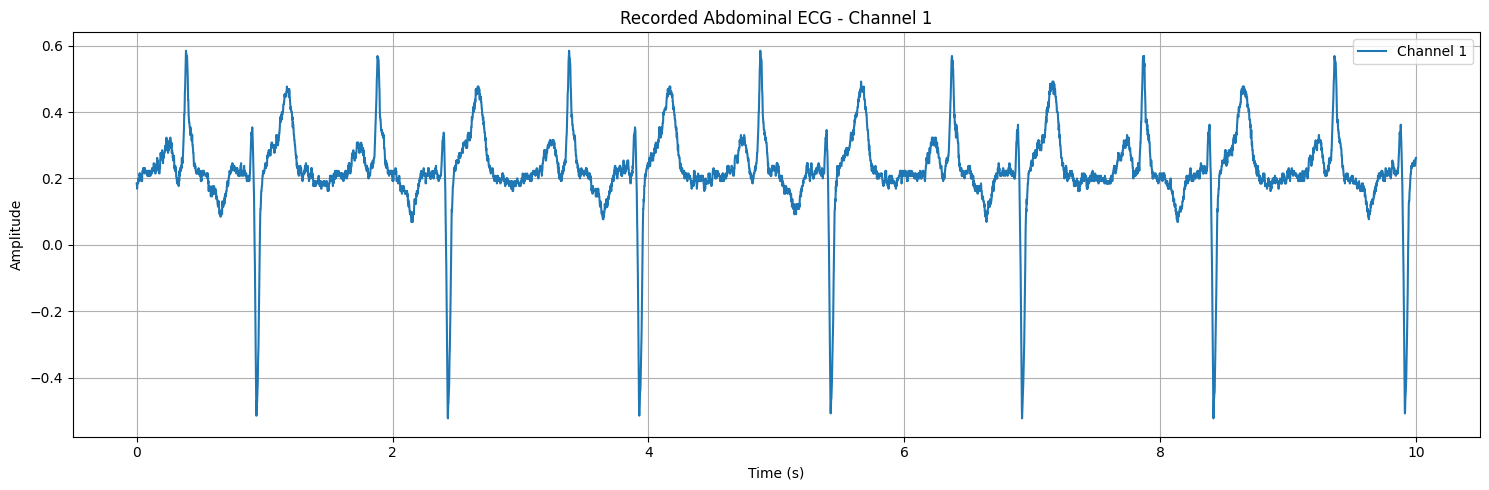

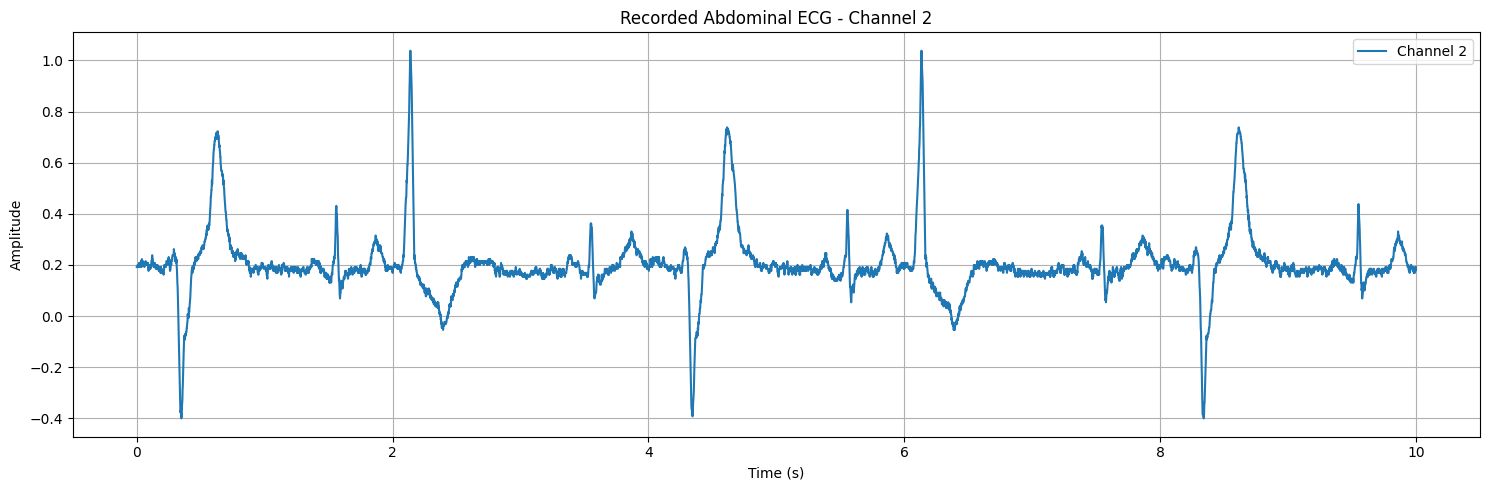

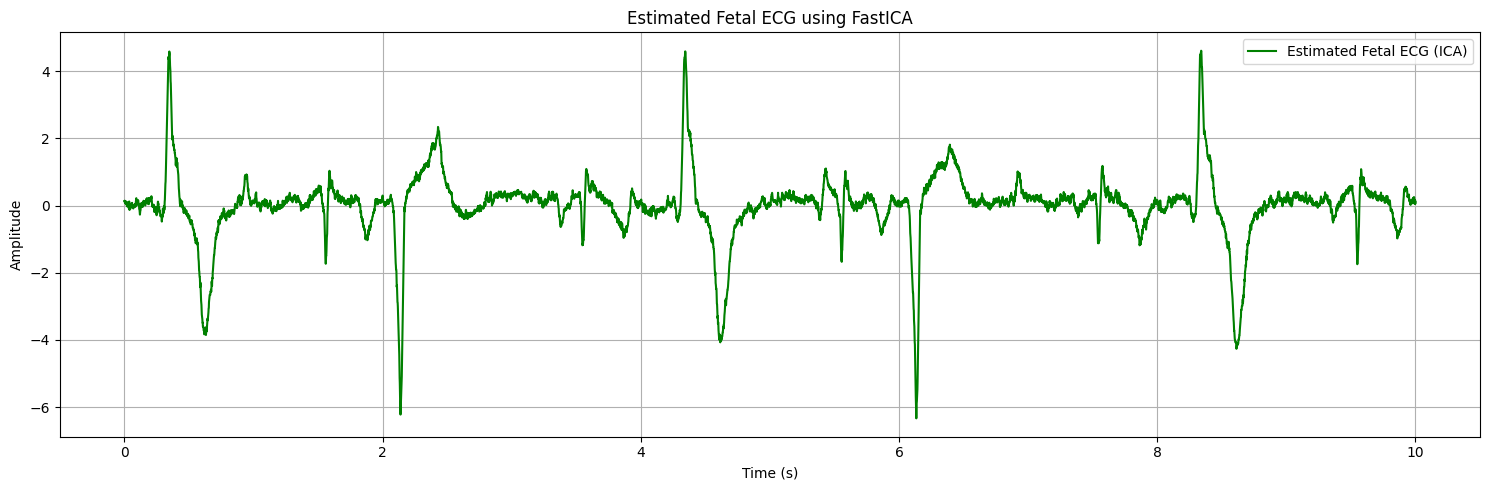

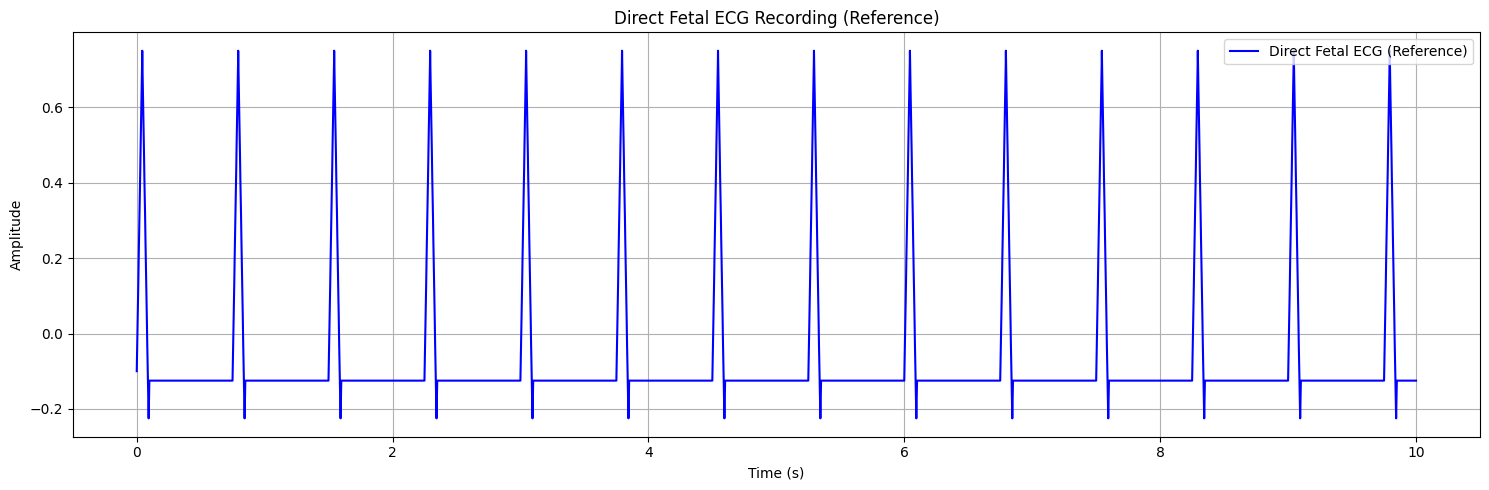

Estimated Mixing Matrix A_ica (Channel Contributions to Source):
 [[-1.03860158]
 [-7.62017785]]

Estimated Components Matrix W_ica (Weights for Source Extraction):
 [[-1.03860158 -7.62017785]]

--- ICA Process Explanation for Fetal ECG Extraction ---
1. Data Loaded:
   - Abdominal ECG Channel 1: 7200 samples
   - Abdominal ECG Channel 2: 7200 samples
   - Sampling Frequency (Fs): 720 Hz
   - Duration: ~10.00 seconds

2. Data Preparation:
   - Mixed signals (X_mixed) arranged as an array of shape (7200, 2).
     - Rows represent time points.
     - Columns represent the recorded abdominal ECG channels.

3. FastICA Application:
   - FastICA configured to find n_components=1 source.
   - Assumes the underlying sources are statistically independent.
   - Applies a whitening step internally to decorrelate and normalize the input signals.
   - Uses the 'logcosh' nonlinear function (contrast function) to maximize non-Gaussianity.
   - Finds an unmixing matrix (W_ica_components) to transform 

In [4]:


# --- Load Data ---
# Load the two-channel abdominal ECG recordings
abdominal_ecg_data = np.loadtxt('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ecg-aami3a.txt')
abdominal_ecg_data1 = np.loadtxt('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ecg-aami3b.txt')

# Extract the relevant signal columns (assuming column 1)
abdominal_signal_1 = abdominal_ecg_data[:, 1]
abdominal_signal_2 = abdominal_ecg_data1[:, 1]

# Load the reference direct fetal ECG recording
fetal_ecg_data = np.loadtxt('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ecg-aami4a.txt')
# Extract the relevant signal column (assuming column 1)
fetal_signal_direct = fetal_ecg_data[:, 1]

# Define sampling frequency (adjust if different)
Fs = 720  # Hz

# --- Prepare Data for ICA ---
# Combine the abdominal ECG channels into a single array for ICA
# Rows are observations (channels), columns are time points (samples)
X_mixed = np.vstack((abdominal_signal_1, abdominal_signal_2)) # Shape (2, N)

# Transpose so that rows are samples and columns are signals (channels)
# This is the typical input format for many ICA implementations
X_mixed = X_mixed.T # Shape (N, 2)

# --- Apply FastICA ---
# Create the FastICA object.
# We expect 1 component (the fetal ECG).
# `whiten='unit-variance'` is a common choice.
# `random_state` ensures reproducibility.
# `fun='logcosh'` is the default and generally good nonlinear function.
# `max_iter=200` increases iterations if needed (default is 200).

transformer = FastICA(
    n_components=1,
    whiten='unit-variance',
    fun='logcosh', # You can try 'exp' or 'cube' as well
    random_state=42, # For reproducible results
    max_iter=500 # Increase if convergence warning occurs
)

# Fit the ICA model to the mixed data and transform it to get the sources
# S_ica will contain the estimated independent components (sources)
# Note: FastICA usually returns sources as (n_components, n_samples) or (n_samples, n_components)
# Sklearn's FastICA.fit_transform returns (n_samples, n_components)
S_ica_sources = transformer.fit_transform(X_mixed) # Shape (N, 1)
# Mixing matrix A_ica
A_ica_mixing = transformer.components_.T # Shape (n_features, n_components)
# Components matrix W_ica (unmixing/transforming matrix)
W_ica_components = transformer.components_ # Shape (n_components, n_channels) -> (1, 2)


# --- Select the Estimated Fetal ECG Source ---
# Sklearn's fit_transform gives us the sources.
# S_ica_sources shape is (N, n_components=1)
# We squeeze to remove the singleton dimension, resulting in (N,)
S_ica_estimated = S_ica_sources.squeeze() # Shape (N,)

# --- Visualization ---

# Determine time axis length (assuming all signals are the same length)
n_samples = len(abdominal_signal_1)
duration_seconds = n_samples / Fs
time_axis = np.linspace(0, duration_seconds, n_samples)

# Plot Abdominal ECG Channel 1
plt.figure(figsize=(15, 5))
plt.plot(time_axis, abdominal_signal_1, label='Channel 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Recorded Abdominal ECG - Channel 1')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Abdominal ECG Channel 2
plt.figure(figsize=(15, 5))
plt.plot(time_axis, abdominal_signal_2, label='Channel 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Recorded Abdominal ECG - Channel 2')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Estimated Fetal ECG (ICA Output)
plt.figure(figsize=(15, 5))
plt.plot(time_axis, S_ica_estimated, label='Estimated Fetal ECG (ICA)', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Estimated Fetal ECG using FastICA')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Direct Fetal ECG Reference (if available and length matches)
if len(fetal_signal_direct) == n_samples:
    plt.figure(figsize=(15, 5))
    plt.plot(time_axis, fetal_signal_direct, label='Direct Fetal ECG (Reference)', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Direct Fetal ECG Recording (Reference)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Warning: Length mismatch. Abdominal ECG: {n_samples}, Direct Fetal ECG: {len(fetal_signal_direct)}. Skipping direct fetal plot.")

# Optional: Plot the mixing matrix
print("Estimated Mixing Matrix A_ica (Channel Contributions to Source):\n", A_ica_mixing)
# Optional: Plot the components matrix (weights used for transformation)
print("\nEstimated Components Matrix W_ica (Weights for Source Extraction):\n", W_ica_components)

# --- Explanation of ICA Process for Fetal ECG ---

print("\n--- ICA Process Explanation for Fetal ECG Extraction ---")
print(f"1. Data Loaded:")
print(f"   - Abdominal ECG Channel 1: {len(abdominal_signal_1)} samples")
print(f"   - Abdominal ECG Channel 2: {len(abdominal_signal_2)} samples")
print(f"   - Sampling Frequency (Fs): {Fs} Hz")
print(f"   - Duration: ~{duration_seconds:.2f} seconds")

print(f"\n2. Data Preparation:")
print(f"   - Mixed signals (X_mixed) arranged as an array of shape {X_mixed.shape}.")
print(f"     - Rows represent time points.")
print(f"     - Columns represent the recorded abdominal ECG channels.")

print(f"\n3. FastICA Application:")
print(f"   - FastICA configured to find n_components=1 source.")
print(f"   - Assumes the underlying sources are statistically independent.")
print(f"   - Applies a whitening step internally to decorrelate and normalize the input signals.")
print(f"   - Uses the 'logcosh' nonlinear function (contrast function) to maximize non-Gaussianity.")
print(f"   - Finds an unmixing matrix (W_ica_components) to transform the mixed data.")

print(f"\n4. Source Estimation:")
print(f"   - The transformation S_ica_sources = X_mixed @ W_ica_components yields the estimated sources.")
print(f"   - Shape of estimated sources before squeezing: {S_ica_sources.shape}")
print(f"   - Shape of final estimated fetal ECG (S_ica_estimated): ({len(S_ica_estimated)},)")
print(f"   - This represents the 1 independent component extracted by ICA.")

print(f"\n5. Results:")
print(f"   - The estimated fetal ECG signal is plotted.")
print(f"   - If lengths match, the direct fetal ECG reference is also plotted for comparison.")
print(f"   - The mixing matrix A_ica shows how much each abdominal channel contributed to the estimated source.")
print(f"   - The goal is for one of the extracted components to resemble the direct fetal ECG reference.")

print(f"\n--- Key Concepts ---")
print(f"- Non-Gaussianity Maximization: ICA works because the maternal ECG, fetal ECG, and noise tend to be more Gaussian than their independent mixture. By maximizing non-Gaussianity, ICA finds directions in the data that correspond to these potentially non-Gaussian sources.")
print(f"- Whitening: This preprocessing step makes the mixed signals uncorrelated and have unit variance, simplifying the ICA problem.")
print(f"- Contrast Function ('logcosh'): This function helps measure and maximize the non-Gaussianity of the estimated components. Different functions (like 'exp' or 'cube') can be tried depending on the data characteristics.")
print(f"- Number of Components: Here, we explicitly asked for 1 component, hoping it would be the fetal ECG. In practice, extracting multiple components and identifying the fetal ECG one post-hoc might be necessary.")
print(f"- Ambiguity: ICA cannot determine the original order or scale of the sources. The extracted signal might need scaling or inversion to match the reference.")


# Verify how FastICA works

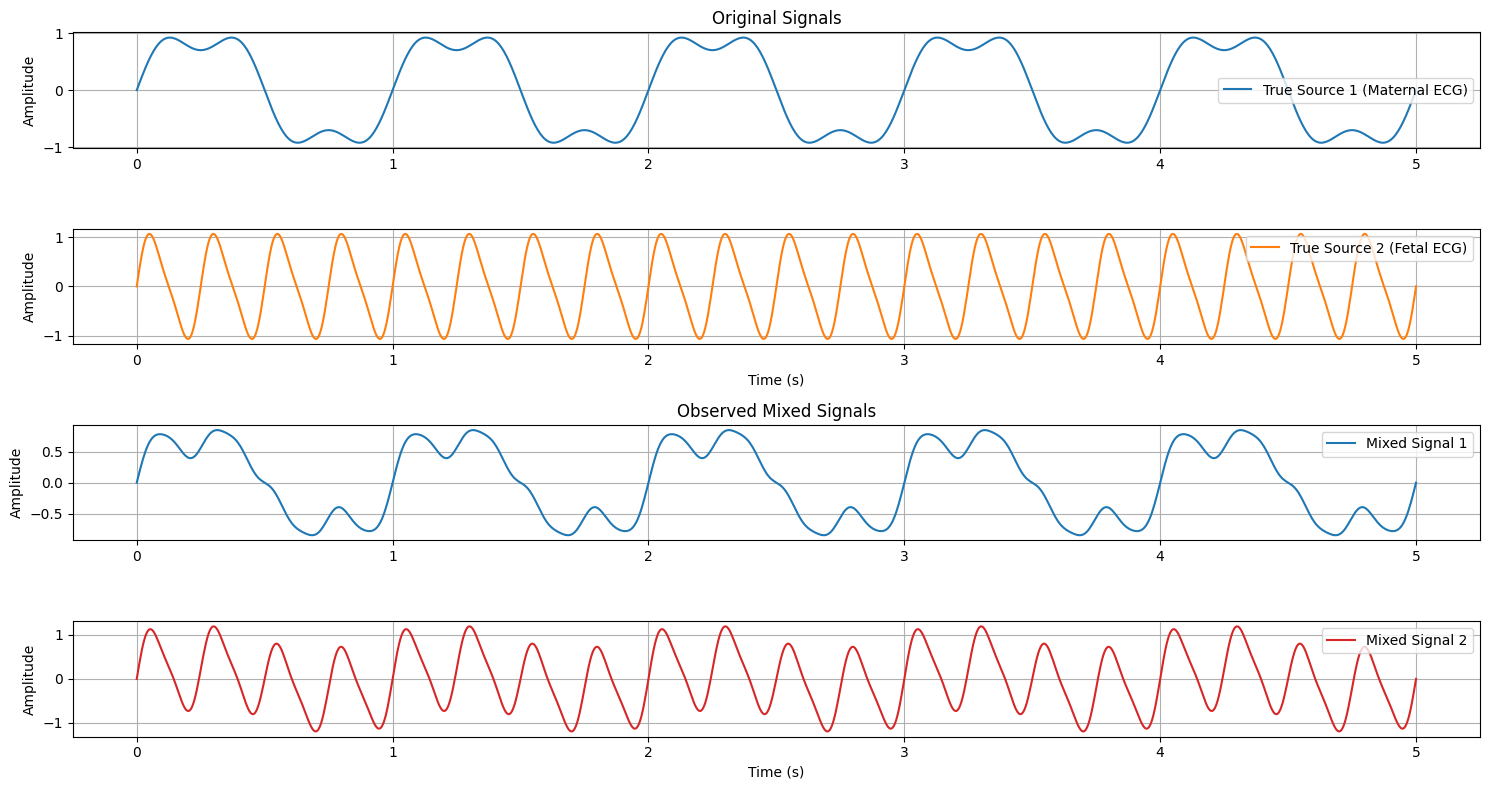

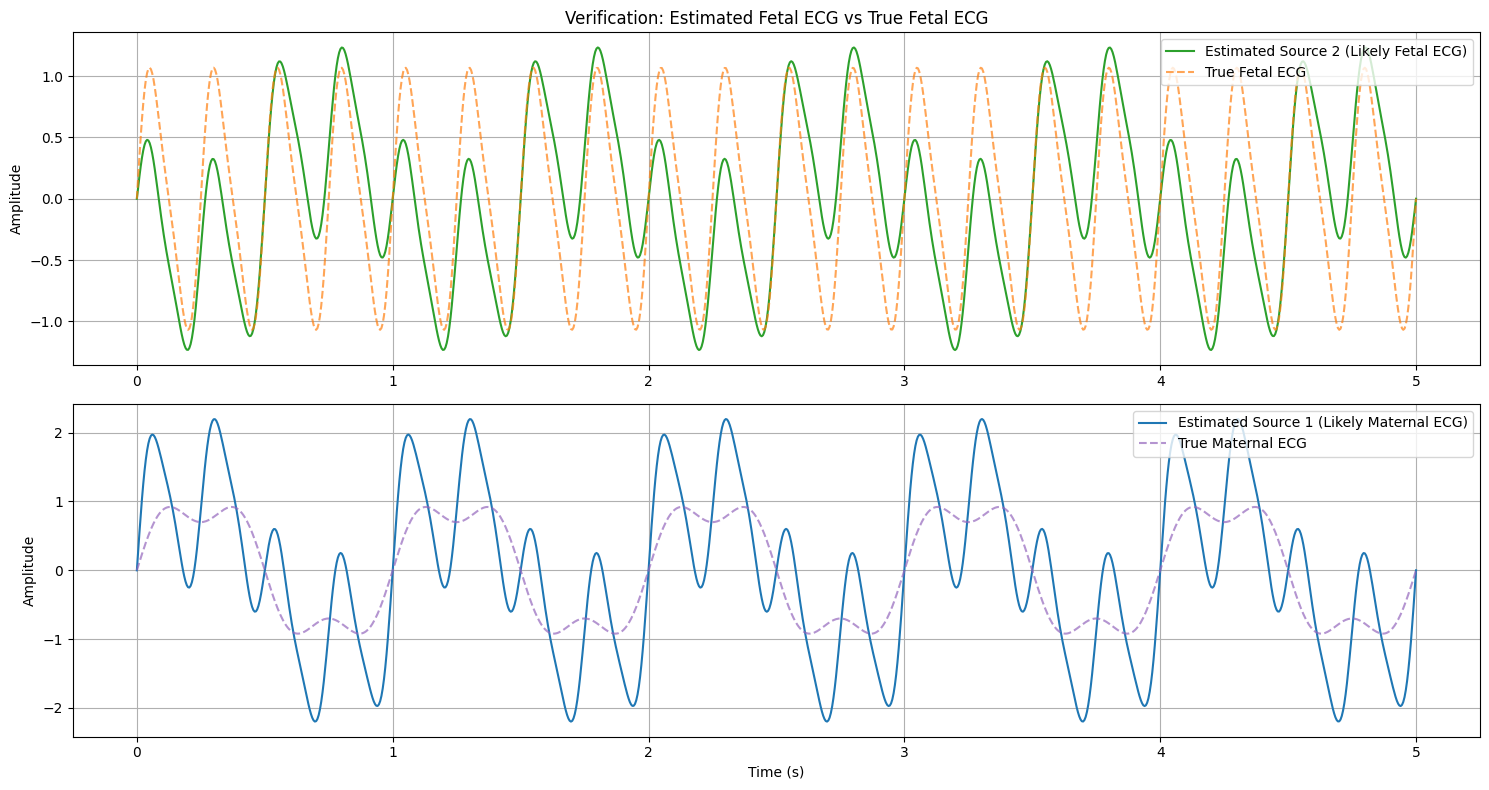

Estimated Unmixing Matrix W:
[[ 0.72659186  0.68706933]
 [-0.68706933  0.72659186]]

True Mixing Matrix A:
[[0.8 0.2]
 [0.3 0.9]]

Correlation between True Fetal ECG and Estimated Source 2: 0.7714
(Note: Scaling and sign might differ due to ICA ambiguities)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la

def g(x, alpha):
    """ Contrast function """
    return np.tanh(alpha * x)

def gdot(x, alpha):
    """ Derivative of contrast function """
    return alpha * (1 - np.tanh(alpha * x)**2)

def fastica(X, comp, max_it=200, tol=1e-6, alpha=1.0, w_init=None):
    '''
    PARAMETERS:
    X(array p,n): "white" array of signals that we need to estimate
    comp(int): independent components that we need to estimate
    max_it(int): maximum iterations of algorithm running
    tol(float): tolerance error that the algorithm converge
    alpha(float): parameter for g and gdot
    w_init(array p,p): initial weights array

    OUTPUTS:
    W(array p,p): estimated un-mixing matrix

    NOTES:
    We use deflational orthogonalization based on Gram-Schidt method
    for un-mixing matrix
    '''
    # Preallocate un-mixing matrix
    W = np.zeros((comp, comp), dtype=np.float64)
    p, n = X.shape
    # We choose comp independent components to estimate
    for i in range(comp):
        # Choose an initial value and normalize it
        w = w_init[i, :].copy()
        w /= la.norm(w)

        # Initialize iterations
        lim = tol + 1
        iterations = 0

        # One-unit algorithm
        while ((lim > tol) and (iterations < max_it - 1)):
            # Calculate w*X product in order to calculate g(w*X) and g'(w*X)
            wtx = np.dot(w, X)[np.newaxis, :]  # shape 1xn
            gdotwtx = gdot(wtx, alpha)         # shape 1xn
            gwtx = g(wtx, alpha)               # shape 1xn

            # the first term of w1 computes the mean value for all the rows of X*g(wX).T (vector)
            # and the second term computes the mean value of g'(w*X) matrix (number)
            w1 = np.mean(X.dot(gwtx.T), axis=1) - np.mean(gdotwtx) * w  # shape 1xp

            # Gram-Schmidt orthogonalization
            temp = np.zeros_like(w1)
            for j in range(i):
                wt = W[j, :].copy()
                # Calculate sum{(w1*wj)wj}
                temp += (w1 @ wt) * wt
            w1 -= temp
            # Normalization
            w1 /= la.norm(w1)

            # Convergence check: | |w1.T * w| - 1 |
            lim = np.abs(np.abs((w1 @ w)) - 1)
            w = w1
            iterations += 1

        W[i, :] = w

    return W

# --- Verification Procedure ---
def verify_fastica():
    """ Demonstrates FastICA using simulated signals """

    # 1. Generate or load original source signals (S) and mixing matrix (A)
    # For demonstration, let's create two simple sources:
    # s1: A dominant maternal ECG-like signal (slower oscillations)
    # s2: A weaker fetal ECG-like signal (faster oscillations, higher frequency)
    np.random.seed(42) # For reproducibility
    n_samples = 1000
    t = np.linspace(0, 5, n_samples) # Time vector

    # Simulate Maternal ECG (dominant, slower)
    s1_clean = np.sin(2 * np.pi * 1.0 * t) + 0.3 * np.sin(2 * np.pi * 3.0 * t) # Fundamental + harmonic
    # Simulate Fetal ECG (weaker, faster)
    s2_clean = np.sin(2 * np.pi * 4.0 * t) + 0.2 * np.sin(2 * np.pi * 8.0 * t) # Higher fundamental + harmonic

    # Stack sources into a matrix S (shape: n_sources, n_samples)
    S_true = np.vstack([s1_clean, s2_clean])

    # Define a mixing matrix A (must be invertible)
    # Example: Maternal ECG appears strongly in both mixtures,
    #          Fetal ECG appears weakly but distinctly.
    A_true = np.array([[0.8, 0.2],
                       [0.3, 0.9]])

    # 2. Create the mixed signals X = A * S
    # Note: FastICA typically works on X.T (samples, features), so we mix as S.T @ A.T
    X_mixed = (S_true.T @ A_true.T).T # Resulting shape: (n_sources, n_samples)

    # 3. Whiten the data X (simplified simulation assuming identity covariance)
    # In practice, you'd calculate the covariance, eigenvalue decomposition,
    # and apply a sphering transform. Here, we'll skip detailed whitening for simplicity
    # and assume X is already approximately white or standardize it.
    # Standardize for basic decorrelation (not full whitening)
    X_mean = np.mean(X_mixed, axis=1, keepdims=True)
    X_centered = X_mixed - X_mean
    # Use standardized data as 'whitened' input for this demo
    X_white = X_centered / np.std(X_centered, axis=1, keepdims=True)

    # 4. Run FastICA
    n_components = S_true.shape[0]
    # Provide initial guess for the unmixing matrix W
    W_init = np.random.normal(size=(n_components, n_components))
    # Ensure initial vectors are normalized
    W_init = W_init / np.linalg.norm(W_init, axis=1, keepdims=True)

    W_estimated = fastica(X_white, comp=n_components, max_it=200, tol=1e-6, alpha=1.0, w_init=W_init)

    # 5. Reconstruct the estimated source signals S_est = W * X
    # Assuming X_white represents the whitened version of the observed signals
    # and the mixing happened before whitening, the reconstruction is S_est = W_est * X_white
    S_est = W_estimated @ X_white

    # Optional: Normalize estimated sources for easier comparison of shape
    # S_est = S_est / np.std(S_est, axis=1, keepdims=True)

    # 6. Plotting
    plt.rcParams["figure.figsize"] = (15, 10)

    # Plot True Sources
    plt.figure(figsize=(15, 8))
    plt.subplot(4, 1, 1)
    plt.plot(t, S_true[0, :], label='True Source 1 (Maternal ECG)')
    plt.title('Original Signals')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 2)
    plt.plot(t, S_true[1, :], label='True Source 2 (Fetal ECG)', color='C1')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.grid(True)

    # Plot Mixed Signals
    plt.subplot(4, 1, 3)
    plt.plot(t, X_mixed[0, :], label='Mixed Signal 1')
    plt.title('Observed Mixed Signals')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 4)
    plt.plot(t, X_mixed[1, :], label='Mixed Signal 2', color='C3')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Estimated Sources vs True Fetal ECG
    plt.figure(figsize=(15, 8))

    # Find the estimated source most correlated with the true fetal ECG
    # (assuming we know which one it should be, or find it automatically)
    # For simplicity, let's plot both estimated sources and identify visually.
    # In practice, you'd need to resolve permutation and scaling ambiguities.
    correlations_s2 = [np.corrcoef(S_true[1, :], S_est[i, :])[0, 1] for i in range(n_components)]
    # Find the index of the estimated source with highest correlation to s2 (fetal ECG)
    fetal_index = np.argmax(np.abs(correlations_s2))
    maternal_index = 1 - fetal_index # Assuming only 2 sources

    plt.subplot(2, 1, 1)
    # Plot the estimated fetal ECG signal
    plt.plot(t, S_est[fetal_index, :], label=f'Estimated Source {fetal_index+1} (Likely Fetal ECG)', color='C2')
    # Plot the true fetal ECG signal for comparison
    plt.plot(t, S_true[1, :], '--', label='True Fetal ECG', color='C1', alpha=0.7)
    plt.title('Verification: Estimated Fetal ECG vs True Fetal ECG')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    # Plot the estimated maternal ECG signal
    plt.plot(t, S_est[maternal_index, :], label=f'Estimated Source {maternal_index+1} (Likely Maternal ECG)', color='C0')
    # Plot the true maternal ECG signal for comparison
    plt.plot(t, S_true[0, :], '--', label='True Maternal ECG', color='C4', alpha=0.7)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Estimated Unmixing Matrix W:")
    print(W_estimated)
    print(f"\nTrue Mixing Matrix A:")
    print(A_true)
    print(f"\nCorrelation between True Fetal ECG and Estimated Source {fetal_index+1}: {correlations_s2[fetal_index]:.4f}")
    print(f"(Note: Scaling and sign might differ due to ICA ambiguities)")

# Run the verification
verify_fastica()